# 1. Data Collection

## 1. Web Scraping for Assets principal Info

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import os
import os.path

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions

In [ ]:
driver = webdriver.Chrome("./chromedriver")
driver.get('https://www.metrocuadrado.com/arriendo/?search=form')

In [ ]:
# Maximum number of pages to scrape
def get_max_pages(driver):
  pages = driver.find_elements_by_class_name('page-link')
  value = pages[len(pages)-3].text

  return int(value)
#------------------------------------

# append the links to the link array
def get_links(d,link):
    length = len(d.find_elements_by_xpath("//li[@class='sc-gPEVay dibcyk card-result-img']/a"))
    for i in range(0,length):
        link.append(d.find_elements_by_xpath("//li[@class='sc-gPEVay dibcyk card-result-img']/a")[i].get_attribute('href'))
#-------------------------------------


# get into the next page
def get_next_page(driver):
    next_page = driver.find_element_by_css_selector("[aria-label=Next]")
    next_page.send_keys(Keys.RETURN)
#-------------------------------------

# search a specific city in Colombia
def search_city(driver,city):
    input_area = driver.find_elements_by_xpath("//input[@placeholder='Ciudad, Zona o Barrio']")[0]
    input_area.send_keys(Keys.CONTROL + "a")
    input_area.send_keys(Keys.BACK_SPACE)
    input_area.send_keys(city)
    search = driver.find_element_by_id('btnSearch')
    search.send_keys(Keys.RETURN)
#-------------------------------------

# create a dataFrame with the info
def create_info(driver,df):
    length = len(driver.find_elements_by_xpath("//li[@class='sc-gPEVay dibcyk card-result-img']/a[@class='sc-bdVaJa ebNrSm']"))
    initial = len(df.index)
    for i in range(0 ,length):
        anchor = driver.find_elements_by_xpath("//li[@class='sc-gPEVay dibcyk card-result-img']/a[@class='sc-bdVaJa ebNrSm']")[i]
        source = anchor.get_attribute('href')
        product_name = anchor.get_attribute('data-gtm-productname')
        product_sku = anchor.get_attribute('data-gtm-productsku')
        product_price = anchor.get_attribute('data-gtm-productprice')
        product_category = anchor.get_attribute('data-gtm-productcategory')
        city = anchor.get_attribute('data-gtm-city')
        zone = anchor.get_attribute('data-gtm-zone')
        neighborhood = anchor.get_attribute('data-gtm-neighborhood')
        business_type = anchor.get_attribute('data-gtm-businesstype')
        property_type = anchor.get_attribute('data-gtm-propertytype')
        to_append = [source,product_name,product_sku,product_price,product_category,city,zone,neighborhood,business_type,property_type]
        df.loc[initial] = to_append
        initial = initial 

In [ ]:
import time
links = []
def fetch_all_links(driver,city,df):
    search_city(driver,city)
    max_pages = get_max_pages(driver)
    print()
    for i in range(1,max_pages+1):
        time.sleep(7)
        create_info(driver,df)
        get_next_page(driver)
        

In [ ]:
columns = ['source','product_name','product_sku','product_price','product-category','city','zone','neighborhood','business_type','property_type']
df = pd.DataFrame(columns=columns)
fetch_all_links(driver,'bogota',df)

## 2. Web Scraping for Assets detailed Info

In [ ]:
# function for getting the area
def get_area(driver,array):
    datos = driver.find_elements_by_xpath("//div[@class='Card-sc-18qyd5o-0 jYfunq sc-caSCKo fizDQf sc-kgAjT bIrfOA feature mb-4 sc-kgAjT bIrfOA feature mb-4 card-line card']/div/div/div/h2/div/div")
    arreglo = []
    
    datos = datos[0].text.split('\n')
    arreglo.append(datos)
    array.append(arreglo[0])
#-------------------------------

# function for getting the other parameters
def get_params_data(driver,values):
    arreglo = []
    data = driver.find_elements_by_xpath("//div[@class='Col-sc-14ninbu-0 lfGZKA text-center col-12']/ul/li/h2")
    for i in range(0,len(data)):
        datos = [data[i].text.split('\n')][0]
        datos[0],datos[1] = datos[1],datos[0]
        arreglo.append(datos)
    values.extend(arreglo)

#-------------------------------

# function for getting all params

#---------------------------

# function for getting datos principales
def create_dp(driver,values):
    name = driver.find_elements_by_xpath("//div[@class='Card-sc-18qyd5o-0 jYfunq sc-caSCKo fizDQf sc-TOsTZ spozq realstatedata mb-3 sc-TOsTZ spozq realstatedata mb-3 card-details card']/div/div/h3")
    ref = driver.find_elements_by_xpath("//div[@class='Card-sc-18qyd5o-0 jYfunq sc-caSCKo fizDQf sc-TOsTZ spozq realstatedata mb-3 sc-TOsTZ spozq realstatedata mb-3 card-details card']/div/div/p")
    for i in range(0,len(name)):
        value = [name[i].text,ref[i].text]
        values.append(value)
#------------------------------

# function for fetching a specific page and getting the data
def specific_page(driver,array):
    values = []
    #get_area(driver,values)
    get_params_data(driver,values)
    create_dp(driver,values)
    array.append(values)
#------------------------------

In [ ]:
# function to save an array
def save_array(array):
    new_array = []
    lista = ['Área construida',
     'Habitaciones',
     'Código inmueble',
     'Barrio común',
     'Precio',
     'Antigüedad',
     'Área construida',
     'Área privada',
     'Parqueaderos']
    new_array = pd.DataFrame(new_array)
    
    for i in range(0,len(array)):
        if array[i]:
            data = pd.DataFrame(array[i]).T
            data.columns = list(data.loc[0].values)
            data = data[1:]
            new_array = pd.concat([new_array,data])
    return new_array
#--------------------------------------------------

# function for check logs
def save_position(array,table_name):
    length = len(array)
    new_df = pd.DataFrame([length], columns=['length'])
    new_df.to_csv('indicador_'+table_name+'.csv')
#-------------------------------------------------

# Function for knowing the starting position 
def start_index(titulo):
    path = 'indicador_'+titulo+'.csv'
    if os.path.isfile(path):
        df2 = pd.read_csv(path)
        return df2['length'].loc[0]
    else :
        return 1
#-----------------------------------------

def load_array(titulo):
    import pickle
    path = 'indicador_'+titulo+'.pickle'
    if os.path.isfile(path):
        with open(path, 'rb') as handle:
            data = pickle.load(handle)
            return data
    else:
        return []
    
def save_array_pickle(titulo,array):
    import pickle
    a = array
    path = 'indicador_'+titulo+'.pickle'
    with open(path, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
path = 'compra_usado_bogota'
array = load_array(path)
df = pd.read_csv(path +'.csv')
datos = df['source']

desde = start_index(path)

for i in range(desde-1,len(datos)):
    driver.get(datos.loc[i])
    specific_page(driver,array)
    if i % 1 == 0:
        arreglito = save_array(array)
        arreglito.to_csv(path+'datos_especificos.csv')
        save_position(array,path)
        save_array_pickle(path,array)

# 2. Data Analysis

In [9]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%cd '/content/drive/MyDrive/ML Projects/Bogota housing'

/content/drive/MyDrive/ML Projects/Bogota housing


In [ ]:
df = pd.read_csv('./compra_usado_bogota.csv')

In [ ]:
df_second = pd.read_csv('./compra_usado_bogotadatos_especificos.csv')

## 1. Exploratory Data Analysis for two datasets


1.   Apartment Listing - df
2.   Apartment Specific info - df_second



In [ ]:
df.head()

,Unnamed: 0,source,product_name,product_sku,product_price,product-category,city,zone,neighborhood,business_type,property_type
0,0,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005003,650000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento
1,1,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005023,1500000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento
2,2,https://www.metrocuadrado.com/inmueble/venta-c...,"Casa en Venta, Bogota, Bogotá D.C.",11812-M3005022,1600000000,venta - Casa,Bogotá D.C.,NaN,BOGOTA,venta,Casa
3,3,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005002,330000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento
4,4,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005033,2300000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento


In [ ]:
df_second.head()

,Unnamed: 0,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada,Parqueaderos,Valor administración,Valor arriendo
0,1,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²,1.0,NaN,NaN
1,1,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²,2.0,$1.100.000,NaN
2,1,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²,1.0,NaN,NaN
3,1,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²,1.0,$260.000,NaN
4,1,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²,1.0,NaN,NaN


In [ ]:
df_second['Código inmueble'].value_counts()>1

779-6021           True
34-62061           True
3312-M2911991      True
847-5559L1         True
11295-M2920927     True
                  ...  
2259-3096065      False
2592-614          False
3491-M2984930     False
MC26120805        False
10200-M3012456    False
Name: Código inmueble, Length: 7302, dtype: bool

In [ ]:
unique_values = list(df.product_sku.unique())

In [ ]:
len(unique_values)

7464

In [ ]:
df = df[df['product_sku'].duplicated() == False]

In [ ]:
df_second = df_second[df_second['Código inmueble'].duplicated()== False]

## 2. Merge Both Data Frames

In [ ]:
houses = df.merge(df_second,left_on='product_sku',right_on='Código inmueble',how='right')

In [ ]:
len(df_second)

7302

In [ ]:
len(df)-len(df_second)

162

In [ ]:
houses[houses.Estrato.isna() & houses['Barrio común'].isna() & houses.Precio.isna() & houses.Antigüedad.isna() & houses['Área construida'].isna()]

,Unnamed: 0_x,source,product_name,product_sku,product_price,product-category,city,zone,neighborhood,business_type,property_type,Unnamed: 0_y,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada,Parqueaderos,Valor administración,Valor arriendo


In [ ]:
houses.head()

,Unnamed: 0_x,source,product_name,product_sku,product_price,product-category,city,zone,neighborhood,business_type,property_type,Unnamed: 0_y,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada,Parqueaderos,Valor administración,Valor arriendo
0,0,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005003,650000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento,1,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²,1.0,NaN,NaN
1,1,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005023,1500000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento,1,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²,2.0,$1.100.000,NaN
2,2,https://www.metrocuadrado.com/inmueble/venta-c...,"Casa en Venta, Bogota, Bogotá D.C.",11812-M3005022,1600000000,venta - Casa,Bogotá D.C.,NaN,BOGOTA,venta,Casa,1,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²,1.0,NaN,NaN
3,3,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005002,330000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento,1,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²,1.0,$260.000,NaN
4,4,https://www.metrocuadrado.com/inmueble/venta-a...,"Apartamento en Venta, Bogota, Bogotá D.C.",11812-M3005033,2300000000,venta - Apartamento,Bogotá D.C.,NaN,BOGOTA,venta,Apartamento,1,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²,1.0,NaN,NaN


In [ ]:
houses.columns

Index(['Unnamed: 0_x', 'source', 'product_name', 'product_sku',
       'product_price', 'product-category', 'city', 'zone', 'neighborhood',
       'business_type', 'property_type', 'Unnamed: 0_y', 'Habitaciones',
       'Baños', 'Estrato', 'Código inmueble', 'Barrio común', 'Precio',
       'Antigüedad', 'Área construida', 'Área privada', 'Parqueaderos',
       'Valor administración', 'Valor arriendo'],
      dtype='object')

In [ ]:
houses = houses.drop(['product_name','Unnamed: 0_x','source','product_sku','zone','neighborhood','Unnamed: 0_y','Parqueaderos','Valor administración','Valor arriendo'],axis=1)

In [ ]:
houses.property_type.unique()

array(['Apartamento', 'Casa', 'Edificio de Oficinas', 'Lote o Casalote',
       'Oficina', 'Bodega', 'Consultorio', 'Local Comercial',
       'Edificio de Apartamentos', 'Finca'], dtype=object)

## 3. Split data frame for houses and apartments only

In [ ]:
habitacional = houses[(houses.property_type == 'Apartamento') | (houses.property_type == 'Casa')]

In [ ]:
habitacional[habitacional.Habitaciones.isnull()]

,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada
81,1150000000,venta - Casa,Bogotá D.C.,venta,Casa,NaN,5.0,5.0,401-I1842336,NaN,$1.150.000.000,Más de 20 años,416 m²,365 m²
3258,2500000000,venta - Casa,Bogotá D.C.,venta,Casa,NaN,NaN,4.0,3229-951754,LOS CEDRITOS,$2.500.000.000,Entre 10 y 20 años,287 m²,287 m²
3860,616104563,venta - Apartamento,Bogotá D.C.,venta,Apartamento,NaN,5.0,5.0,34-4387,Chia,$616.104.563,Entre 5 y 10 años,74 m²,74 m²
4429,400000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,NaN,NaN,5.0,MC26133089,CONTADOR,$400.000.000,NaN,84 m²,84 m²
4861,385000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,NaN,NaN,4.0,488-1174,NORMANDIA,$385.000.000,Entre 0 y 5 años,82 m²,0 m²
4922,451000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,NaN,NaN,4.0,488-1173,NORMANDIA,$451.000.000,Entre 0 y 5 años,102 m²,0 m²
4996,650000000,venta - Casa,Bogotá D.C.,venta,Casa,NaN,3.0,3.0,603-I1859221,KENNEDY,$650.000.000,Más de 20 años,157 m²,157 m²
5962,300000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,NaN,1.0,6.0,2398-20282,EL CHICO,$300.000.000,Entre 10 y 20 años,46 m²,59 m²
6353,1200000000,venta - Casa,Bogotá D.C.,venta,Casa,NaN,NaN,2.0,VENT-04698101,EL REFUGIO,$1.200.000.000,Entre 10 y 20 años,292 m²,292 m²
6975,700000000,venta - Casa,Bogotá D.C.,venta,Casa,NaN,NaN,3.0,3222-I1842600,EL RESTREPO,$700.000.000,Entre 5 y 10 años,243 m²,243 m²


## 4. Data Cleaning 

In [ ]:
habitacional = habitacional.dropna(axis=0, subset=['Habitaciones'])

In [ ]:
habitacional['Baños']=habitacional.groupby('Habitaciones')['Baños'].apply(lambda x:x.fillna(np.round(x.mean(),decimals=0)))

In [ ]:
habitacional

,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada
0,650000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²
1,1500000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²
2,1600000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²
3,330000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²
4,2300000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297,960000000,Venta y Arriendo - Apartamento,Bogotá D.C.,Venta y Arriendo,Apartamento,1.0,2.0,6.0,3241-M2608932,CHICO,$960.000.000,Entre 10 y 20 años,157 m²,137 m²
7298,198000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,1.0,4.0,3147-M2386346,chapinero,$198.000.000,Entre 0 y 5 años,24 m²,24 m²
7299,1920000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,4.0,6.0,1265-1793008,Chico Alto,$1.920.000.000,Más de 20 años,285 m²,285 m²
7300,310000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,5.0,1265-3291705,Pasadena,$310.000.000,Más de 20 años,72 m²,72 m²


In [ ]:
habitacional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6142 entries, 0 to 7301
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_price     6142 non-null   int64  
 1   product-category  6142 non-null   object 
 2   city              6142 non-null   object 
 3   business_type     6142 non-null   object 
 4   property_type     6142 non-null   object 
 5   Habitaciones      6142 non-null   float64
 6   Baños             6142 non-null   float64
 7   Estrato           5908 non-null   float64
 8   Código inmueble   6142 non-null   object 
 9   Barrio común      6109 non-null   object 
 10  Precio            6142 non-null   object 
 11  Antigüedad        6132 non-null   object 
 12  Área construida   6142 non-null   object 
 13  Área privada      6142 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 879.8+ KB


In [ ]:
habitacional = habitacional.dropna(axis=0, subset=['Barrio común'])

In [ ]:
habitacional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6109 entries, 0 to 7301
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_price     6109 non-null   int64  
 1   product-category  6109 non-null   object 
 2   city              6109 non-null   object 
 3   business_type     6109 non-null   object 
 4   property_type     6109 non-null   object 
 5   Habitaciones      6109 non-null   float64
 6   Baños             6109 non-null   float64
 7   Estrato           5887 non-null   float64
 8   Código inmueble   6109 non-null   object 
 9   Barrio común      6109 non-null   object 
 10  Precio            6109 non-null   object 
 11  Antigüedad        6099 non-null   object 
 12  Área construida   6109 non-null   object 
 13  Área privada      6109 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 715.9+ KB


In [ ]:
habitacional['Antigüedad']=habitacional['Antigüedad'].fillna('Entre 10 y 20 años')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
habitacional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6109 entries, 0 to 7301
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_price     6109 non-null   int64  
 1   product-category  6109 non-null   object 
 2   city              6109 non-null   object 
 3   business_type     6109 non-null   object 
 4   property_type     6109 non-null   object 
 5   Habitaciones      6109 non-null   float64
 6   Baños             6109 non-null   float64
 7   Estrato           5887 non-null   float64
 8   Código inmueble   6109 non-null   object 
 9   Barrio común      6109 non-null   object 
 10  Precio            6109 non-null   object 
 11  Antigüedad        6109 non-null   object 
 12  Área construida   6109 non-null   object 
 13  Área privada      6109 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 715.9+ KB


In [ ]:
habitacional.groupby('Estrato')['product_price'].mean()

Estrato
1.0    1.069125e+09
2.0    2.797886e+08
3.0    4.167389e+08
4.0    5.835867e+08
5.0    1.770486e+09
6.0    1.953104e+09
Name: product_price, dtype: float64

In [ ]:
habitacional[habitacional.Estrato == 1]

,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada
83,160000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,3.0,1.0,3222-M2524559,PAERCELACION BOGOTA,$160.000.000,Entre 10 y 20 años,105 m²,103 m²
165,6500000,venta - Casa,Guarne,venta,Casa,1.0,1.0,1.0,MC2689779,Autopista Medellin - Bogotá,$6.500.000,Entre 0 y 5 años,9 m²,9 m²
216,200000000,venta - Casa,Anolaima,venta,Casa,5.0,3.0,1.0,MC2752419,Juan José Rondón (BOGOTA),$200.000.000,Entre 10 y 20 años,230 m²,140 m²
1057,300000000,venta - Casa,Bogotá D.C.,venta,Casa,5.0,4.0,1.0,11813-M2986962,Engativa,$300.000.000,Entre 0 y 5 años,120 m²,120 m²
1085,250000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,3.0,1.0,11813-M2986663,Suba,$250.000.000,Entre 0 y 5 años,82 m²,82 m²
1097,125000000,venta - Apartamento,Cundinamarca,venta,Apartamento,3.0,1.0,1.0,11813-M2986782,Bogota,$125.000.000,Entre 0 y 5 años,43 m²,43 m²
1246,155000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,1.0,1.0,11813-M3017449,Suba,$155.000.000,Más de 20 años,46 m²,46 m²
4535,183000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,2.0,1.0,11813-M2986615,Kennedy,$183.000.000,Entre 0 y 5 años,65 m²,65 m²
4538,480000000,venta - Casa,Bogotá D.C.,venta,Casa,5.0,5.0,1.0,11813-M2986608,Engativa,$480.000.000,Entre 0 y 5 años,196 m²,196 m²
4823,410000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,1.0,1.0,3038-M3012190,INGEMAR,$410.000.000,Entre 5 y 10 años,58 m²,58 m²


In [ ]:
habitacional.at[5818,'Habitaciones'] = 6

In [ ]:
habitacional.at[5818,'Estrato'] = 6

In [ ]:
habitacional.groupby('Estrato')['product_price'].mean()

Estrato
1.0    2.572273e+08
2.0    2.797886e+08
3.0    4.167389e+08
4.0    5.835867e+08
5.0    1.770486e+09
6.0    1.955869e+09
Name: product_price, dtype: float64

In [ ]:
def apply_estrato(df):
  if df<=2.5e+08:
    return 1
  elif df <= 2.8e+08:
    return 2
  elif df <= 4.16e+08:
    return 3
  elif df <= 5.8e+08:
    return 4
  elif df <= 1.77e+09:
    return 5
  elif df >= 1.95e+09:
    return 6

In [ ]:
apply_estrato(1500000000)

5

In [ ]:
#habitacional[habitacional.Estrato.isna()]['Estrato'] = 
habitacional[habitacional.Estrato.isna()]['product_price'].apply(lambda x: apply_estrato(x))

191     5.0
203     4.0
284     6.0
285     6.0
298     3.0
       ... 
7154    6.0
7172    6.0
7192    5.0
7210    5.0
7231    5.0
Name: product_price, Length: 222, dtype: float64

In [ ]:
habitacional[habitacional.Estrato.isna()]['Estrato'] = habitacional[habitacional.Estrato.isna()]['product_price'].apply(lambda x: apply_estrato(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
estrato_na = list(habitacional[habitacional.Estrato.isna()].index)

In [ ]:
for i in estrato_na:
  habitacional.loc[i,'Estrato'] = apply_estrato(habitacional.loc[i,'product_price'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
#list(habitacional['Barrio común'].unique())

In [ ]:
habitacional[(habitacional['Barrio común']=='Bogota') | (habitacional['Barrio común']=='bogota') | (habitacional['Barrio común']=='BOGOTA') |  (habitacional['Barrio común']=='FUERA DE BOGOTA') | (habitacional['Barrio común']=='Bogotá') ]

,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Barrio común,Precio,Antigüedad,Área construida,Área privada
0,650000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²
1,1500000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²
2,1600000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²
3,330000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²
4,2300000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,400000000,venta - Apartamento,Cundinamarca,venta,Apartamento,2.0,2.0,5.0,11813-M2986476,Bogota,$400.000.000,Entre 0 y 5 años,72 m²,72 m²
59,350000000,venta - Apartamento,Abejorral,venta,Apartamento,3.0,2.0,4.0,MC2953743,Bogota,$350.000.000,Entre 10 y 20 años,51 m²,51 m²
62,250000000,venta - Casa,Cundinamarca,venta,Casa,5.0,2.0,3.0,11813-M2986389,Bogota,$250.000.000,Entre 0 y 5 años,144 m²,72 m²
1097,125000000,venta - Apartamento,Cundinamarca,venta,Apartamento,3.0,1.0,1.0,11813-M2986782,Bogota,$125.000.000,Entre 0 y 5 años,43 m²,43 m²


In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="coordinates_bogota")

def get_location(neighbor):
  location = geolocator.geocode(neighbor +',bogota colombia')
  if location:
    longi = location.longitude
    lati = location.latitude
    return  lati,longi
  else :
    return 0,0

In [ ]:
habitacional = habitacional.rename(columns={'Barrio común':'barrio_comun'})

In [ ]:
habitacional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6109 entries, 0 to 7301
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_price     6109 non-null   int64  
 1   product-category  6109 non-null   object 
 2   city              6109 non-null   object 
 3   business_type     6109 non-null   object 
 4   property_type     6109 non-null   object 
 5   Habitaciones      6109 non-null   float64
 6   Baños             6109 non-null   float64
 7   Estrato           6106 non-null   float64
 8   Código inmueble   6109 non-null   object 
 9   barrio_comun      6109 non-null   object 
 10  Precio            6109 non-null   object 
 11  Antigüedad        6109 non-null   object 
 12  Área construida   6109 non-null   object 
 13  Área privada      6109 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 875.9+ KB


In [ ]:
array = np.array(habitacional.barrio_comun)

In [ ]:
import pickle
if coor:
  print('yes')
else:
  coor = []

yes


In [ ]:
coor=[]

In [ ]:
numero = len(coor)
for i in range(len(coor),len(array)):
  print(numero)
  lati,longi = get_location(array[i])
  value = (array[i],lati,longi)
  coor.append(value)

  if numero % 5 == 0:
    with open('coor.pickle', 'wb') as handle:
      pickle.dump(coor, handle, protocol=pickle.HIGHEST_PROTOCOL)

  numero = numero + 1

6108


In [ ]:
with open('coor.pickle', 'wb') as handle:
      pickle.dump(coor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
coordinates = pd.DataFrame(coor, columns=['barrio','latitude','longitude'])

In [ ]:

for i in list(coordinates[(coordinates.barrio=='Chico Alto') | (coordinates.barrio == 'CHICO ALTO')].index):
  coordinates.loc[i,'latitude'] = 4.6684257
  coordinates.loc[i,'longitude'] = -74.0492742

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                  latitude  longitude
CEDRITOS CONTADOR       0.0       0.0          10
Gran Granada            0.0       0.0          10
CHICO LOS ROSALES       0.0       0.0           9
CHICO - VIRREY          0.0       0.0           9
CHICO VIRREY            0.0       0.0           8
                                               ..
LAS ACASIAS USAQUEN     0.0       0.0           1
LA PORCINCULA           0.0       0.0           1
LA ESTRADA - Normandía  0.0       0.0           1
LA CALLEJA ALCALA       0.0       0.0           1
A.S.D.                  0.0       0.0           1
Length: 178, dtype: int64

In [ ]:
coordinates[coordinates.barrio == 'CEDRITOS CONTADOR']

,barrio,latitude,longitude
4372,CEDRITOS CONTADOR,0.0,0.0
4414,CEDRITOS CONTADOR,0.0,0.0
4421,CEDRITOS CONTADOR,0.0,0.0
4492,CEDRITOS CONTADOR,0.0,0.0
5292,CEDRITOS CONTADOR,0.0,0.0
5327,CEDRITOS CONTADOR,0.0,0.0
5428,CEDRITOS CONTADOR,0.0,0.0
5731,CEDRITOS CONTADOR,0.0,0.0
5833,CEDRITOS CONTADOR,0.0,0.0
5845,CEDRITOS CONTADOR,0.0,0.0


In [ ]:
for i in list(coordinates[coordinates.barrio == 'CEDRITOS CONTADOR'].index):
  coordinates.loc[i,'latitude'] = 4.7197162
  coordinates.loc[i,'longitude'] = -74.0486522

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                  latitude  longitude
Gran Granada            0.0       0.0          10
CHICO LOS ROSALES       0.0       0.0           9
CHICO - VIRREY          0.0       0.0           9
CHICO VIRREY            0.0       0.0           8
ALTOS DE LA CABRERA     0.0       0.0           7
                                               ..
LAS ACASIAS USAQUEN     0.0       0.0           1
LA PORCINCULA           0.0       0.0           1
LA ESTRADA - Normandía  0.0       0.0           1
LA CALLEJA ALCALA       0.0       0.0           1
A.S.D.                  0.0       0.0           1
Length: 177, dtype: int64

In [ ]:
for i in list(coordinates[coordinates.barrio == 'Gran Granada'].index):
  coordinates.loc[i,'latitude'] = 4.7220373
  coordinates.loc[i,'longitude'] = -74.1347222

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                  latitude  longitude
CHICO LOS ROSALES       0.0       0.0          9
CHICO - VIRREY          0.0       0.0          9
CHICO VIRREY            0.0       0.0          8
ALTOS DEL REFUGIO       0.0       0.0          7
ALTOS DE LA CABRERA     0.0       0.0          7
                                              ..
LAS ACASIAS USAQUEN     0.0       0.0          1
LA PORCINCULA           0.0       0.0          1
LA ESTRADA - Normandía  0.0       0.0          1
LA CALLEJA ALCALA       0.0       0.0          1
A.S.D.                  0.0       0.0          1
Length: 176, dtype: int64

In [ ]:
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Rosales" 

  if substring in fullstring:
      coordinates.at[i,'latitude'] = 4.6610616
      coordinates.at[i,'longitude'] = -74.0509378

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                  latitude  longitude
CHICO - VIRREY          0.0       0.0          9
CHICO VIRREY            0.0       0.0          8
ALTOS DE LA CABRERA     0.0       0.0          7
ALTOS DEL REFUGIO       0.0       0.0          7
Calleja Alta            0.0       0.0          6
                                              ..
LA PORCINCULA           0.0       0.0          1
LA ESTRADA - Normandía  0.0       0.0          1
LA CALLEJA ALCALA       0.0       0.0          1
LA CABRERA ALTA         0.0       0.0          1
A.S.D.                  0.0       0.0          1
Length: 166, dtype: int64

In [ ]:
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Virrey" 

  if substring in fullstring:
      coordinates.at[i,'latitude'] = 4.6737775
      coordinates.at[i,'longitude'] = -74.0565422

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                     latitude  longitude
ALTOS DE LA CABRERA        0.0       0.0          7
ALTOS DEL REFUGIO          0.0       0.0          7
Calleja Alta               0.0       0.0          6
Los Cedros-Usaquén         0.0       0.0          5
bogota| sector la cabrera  0.0       0.0          5
                                                 ..
LAS ACASIAS USAQUEN        0.0       0.0          1
LA PORCINCULA              0.0       0.0          1
LA ESTRADA - Normandía     0.0       0.0          1
LA CALLEJA ALCALA          0.0       0.0          1
A.S.D.                     0.0       0.0          1
Length: 158, dtype: int64

In [ ]:
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Cabrera" 

  if substring in fullstring:
      coordinates.at[i,'latitude'] = 4.6683739
      coordinates.at[i,'longitude'] = -74.0583992

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Refugio" 
  
  count = count + 1

  if substring in fullstring:
    coordinates.at[i,'latitude'] = 4.6655184
    coordinates.at[i,'longitude'] = -74.0460893

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                    latitude  longitude
Calleja Alta              0.0       0.0          6
Los Cedros-Usaquén        0.0       0.0          5
EL NOGAL ESPARTILLAL      0.0       0.0          4
CEDRITOS ALCALA           0.0       0.0          4
CEDRITOS LISBOA           0.0       0.0          4
                                                ..
MAZURE                    0.0       0.0          1
MODELO NORTE (BOGOTA )    0.0       0.0          1
MOLINOS DEL NORTE BOGOTA  0.0       0.0          1
MONTELOMA                 0.0       0.0          1
A.S.D.                    0.0       0.0          1
Length: 148, dtype: int64

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Calleja" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7114355
    coordinates.at[i,'longitude'] = -74.0523179

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                               latitude  longitude
ANDINO EL RETIRO                     0.0       0.0          4
ALTOS DEL RETIRO                     0.0       0.0          3
Gran granada                         0.0       0.0          3
BELMIRA PALATINO                     0.0       0.0          3
Bosques Del Marques                  0.0       0.0          3
                                                           ..
MONTELOMA                            0.0       0.0          1
Malibú - Alhambra                    0.0       0.0          1
Mazuren (Noroccidente, Bogotá D.C.)  0.0       0.0          1
Monteloma                            0.0       0.0          1
A.S.D.                               0.0       0.0          1
Length: 133, dtype: int64

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Los Cedros" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7215529
    coordinates.at[i,'longitude'] = -74.0381314

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Nogal" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.6627821
    coordinates.at[i,'longitude'] = -74.0568202

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Lisboa" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7157453
    coordinates.at[i,'longitude'] = -74.0378712

1 Cedritos Lisboa
2 Belmira- Lisboa
3 Country Lisboa
4 Country Lisboa
5 Cedritos Lisboa
6 Cedritos Lisboa
7 Cedritos Lisboa


In [ ]:
# with open('coordinates.pickle', 'wb') as handle:
#       pickle.dump(coordinates, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].value_counts()

barrio                                  latitude  longitude
Colina El Plan                          0.0       0.0          2
TORRELADERA                             0.0       0.0          2
villa andrea kenedy bogota              0.0       0.0          1
Cerros De Los Alpes                     0.0       0.0          1
CEDRITOS - ICATA                        0.0       0.0          1
                                                              ..
Mazuren (Noroccidente, Bogotá D.C.)     0.0       0.0          1
Monteloma                               0.0       0.0          1
Niza Antigua                            0.0       0.0          1
Niza Norte (Noroccidente, Bogotá D.C.)  0.0       0.0          1
 Bosques de Mariana                     0.0       0.0          1
Length: 107, dtype: int64

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Belmira" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7187343
    coordinates.at[i,'longitude'] = -74.0321601

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Gran Granada" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7220373
    coordinates.at[i,'longitude'] = -74.1347222

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Contador" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.71538
    coordinates.at[i,'longitude'] = 74.0298937

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Caobos Salazar" 


  if substring in fullstring:
    # count = count + 1
    # print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7286799
    coordinates.at[i,'longitude'] = -74.0367841

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "San Jose" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7662996
    coordinates.at[i,'longitude'] = -74.0707855

1 Bogota| San Jose De Bavaria
2 Bogota| San Jose De Bavaria


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Centro Internacional" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.620003
    coordinates.at[i,'longitude'] = -74.0780407

1 Centro Internacional Bogota - Centro Internacional
2 Centro Internacional Bogota - Centro Internacional


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Los Pantanos - Kennedy" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.64751795617871
    coordinates.at[i,'longitude'] = -74.16871678238934


1 Norte,Chico Norte
2 El Chico Alto
3 Seminario Chico
4 El Chico Alto


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Chico" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.6777937
    coordinates.at[i,'longitude'] = -74.0573336

1 Norte,Chico Norte
2 El Chico Alto
3 Seminario Chico
4 El Chico Alto


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Chicó" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.6777937
    coordinates.at[i,'longitude'] = -74.0573336

1 Chicó Alto


In [ ]:
count = 0
import re
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Bogota" 


  if substring in fullstring:
    value = coordinates.barrio[i].replace(substring,"")
    coordinates.at[i,'barrio'] = re.sub('[^a-zA-Z0-9 \n\.]', "",value)

In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "De Pino" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7238613
    coordinates.at[i,'longitude'] =-74.0274805

1 Bosque De Pinos
2 Bosque De Pinos
3 Bosque De Pinos


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Ceditos" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.724892
    coordinates.at[i,'longitude'] =-74.0436012

1 Ceditos
2 Ceditos


In [ ]:
count = 0
for i in list(coordinates[(coordinates.latitude==0)& (coordinates.longitude ==0)].index):
  #print(coordinates.barrio[i].title())

  fullstring = coordinates.barrio[i].title()
  substring = "Cedrogolf" 


  if substring in fullstring:
    count = count + 1
    print(count,fullstring)
    coordinates.at[i,'latitude'] = 4.7265697
    coordinates.at[i,'longitude'] = -74.0308104

1 Cedrogolf
2 Cedrogolf


In [ ]:
coordinates['barrio'] = coordinates['barrio'].str.title()

In [ ]:
apartamentos_casas = habitacional.merge(coordinates,right_index=True,left_index=True)

In [ ]:
apartamentos_casas

,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,barrio_comun,Precio,Antigüedad,Área construida,Área privada,barrio,latitude,longitude
0,650000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²,Bogota,4.653333,-74.083652
1,1500000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²,Bogota,4.653333,-74.083652
2,1600000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²,Bogota,4.653333,-74.083652
3,330000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²,Bogota,4.653333,-74.083652
4,2300000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²,Bogota,4.653333,-74.083652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297,960000000,Venta y Arriendo - Apartamento,Bogotá D.C.,Venta y Arriendo,Apartamento,1.0,2.0,6.0,3241-M2608932,CHICO,$960.000.000,Entre 10 y 20 años,157 m²,137 m²,Chico,4.673731,-74.051896
7298,198000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,1.0,4.0,3147-M2386346,chapinero,$198.000.000,Entre 0 y 5 años,24 m²,24 m²,Chapinero,4.645355,-74.061938
7299,1920000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,4.0,6.0,1265-1793008,Chico Alto,$1.920.000.000,Más de 20 años,285 m²,285 m²,Chico Alto,4.668426,-74.049274
7300,310000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,5.0,1265-3291705,Pasadena,$310.000.000,Más de 20 años,72 m²,72 m²,Pasadena,4.692712,-74.063035


(4.0, 5.0)

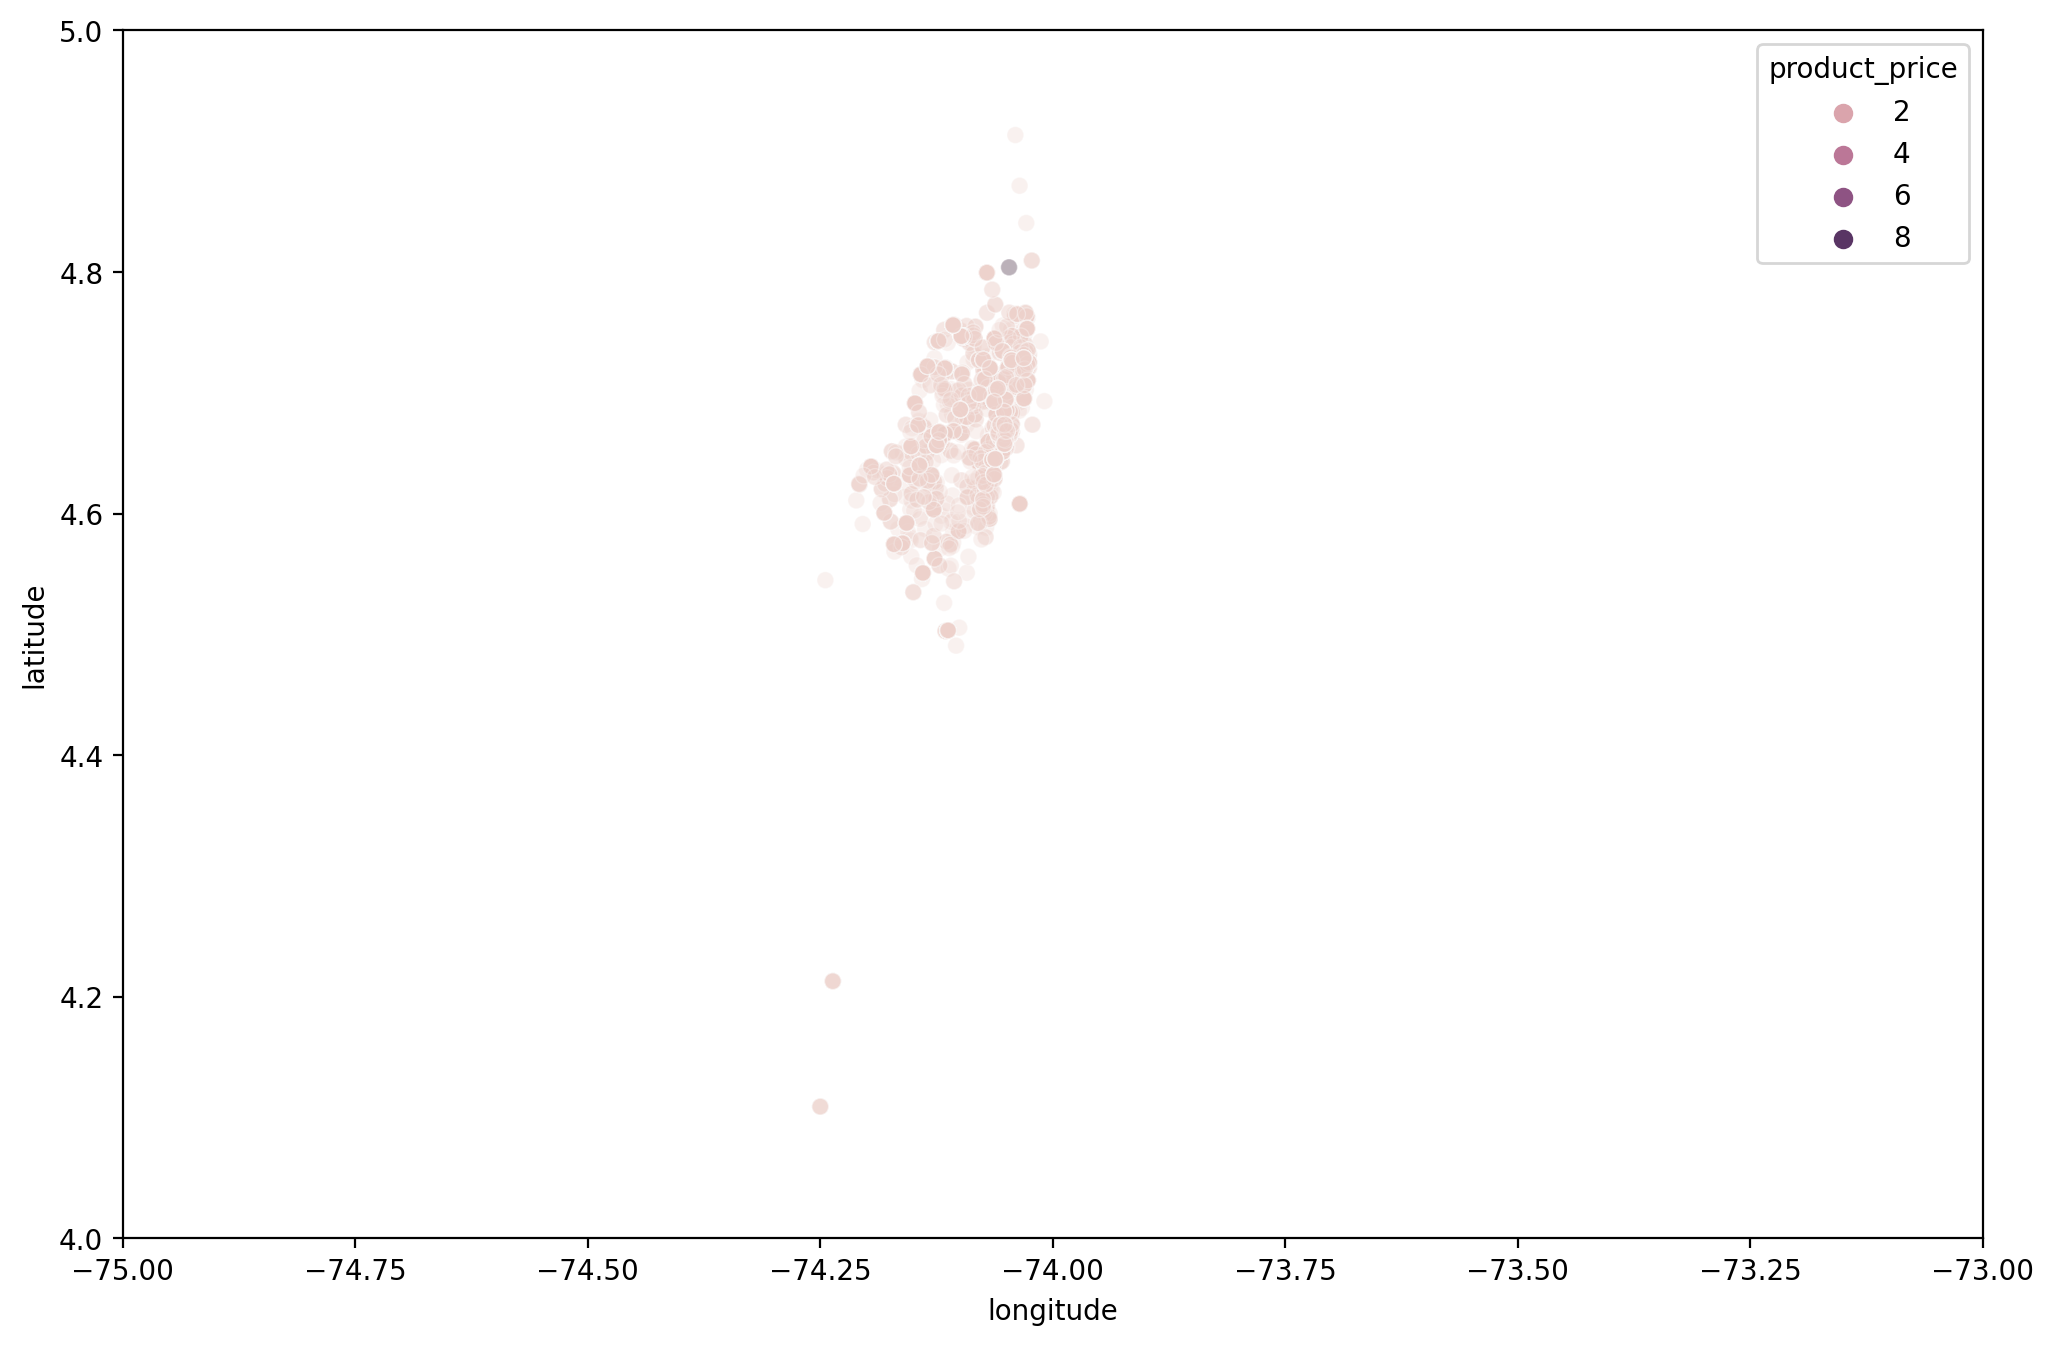

In [ ]:
plt.figure(figsize=(12,8),dpi=200)
sns.scatterplot(data=apartamentos_casas,x='longitude', y='latitude',hue='product_price',alpha=0.3)
plt.xlim(-75,-73)
plt.ylim(4,5)


## 5. Data Frame Ready and complete

In [ ]:
#apartamentos_casas.to_csv('./vivienda_antes_outliers.csv')

In [ ]:
## MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## IMPORTS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## LOAD THE MODEL
apartamentos_casas = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/vivienda_antes_outliers.csv')
apartamentos_casas.head()

,Unnamed: 0,product_price,product-category,city,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,barrio_comun,Precio,Antigüedad,Área construida,Área privada,barrio,latitude,longitude
0,0,650000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Bogota,$650.000.000,Entre 0 y 5 años,102 m²,102 m²,Bogota,4.653333,-74.083652
1,1,1500000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Bogota,$1.500.000.000,Entre 0 y 5 años,210 m²,210 m²,Bogota,4.653333,-74.083652
2,2,1600000000,venta - Casa,Bogotá D.C.,venta,Casa,4.0,4.0,6.0,11812-M3005022,Bogota,$1.600.000.000,Entre 0 y 5 años,2372 m²,500 m²,Bogota,4.653333,-74.083652
3,3,330000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Bogota,$330.000.000,Más de 20 años,53 m²,53 m²,Bogota,4.653333,-74.083652
4,4,2300000000,venta - Apartamento,Bogotá D.C.,venta,Apartamento,3.0,1.0,6.0,11812-M3005033,Bogota,$2.300.000.000,Entre 0 y 5 años,240 m²,240 m²,Bogota,4.653333,-74.083652


#### Remove Outliers

In [ ]:
apartamentos_casas = apartamentos_casas[(apartamentos_casas.latitude >= 4.4) & (apartamentos_casas.latitude <= 5)]
apartamentos_casas = apartamentos_casas[(apartamentos_casas.longitude >= -74.5) & (apartamentos_casas.longitude <= 73.75)]

In [ ]:
apartamentos_casas= apartamentos_casas[~(apartamentos_casas.product_price == apartamentos_casas.product_price.max())]

In [ ]:
apartamentos_casas = apartamentos_casas[apartamentos_casas.product_price<=1.590000e+09]

#### Final Data Frame Ready

In [ ]:
df = apartamentos_casas.copy()
df.describe()

,Unnamed: 0,product_price,Habitaciones,Baños,Estrato,latitude,longitude
count,4413.000000,4.413000e+03,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000
mean,3664.472694,6.996853e+08,2.700431,2.696578,4.710401,4.688954,-74.070532
std,2110.850794,3.887191e+08,0.959276,1.022050,1.186381,0.050934,0.037993
min,0.000000,1.000000e+06,1.000000,1.000000,1.000000,4.490724,-74.244562
25%,1786.000000,3.800000e+08,2.000000,2.000000,4.000000,4.666056,-74.097675
50%,3745.000000,6.200000e+08,3.000000,3.000000,5.000000,4.702627,-74.053564
75%,5425.000000,9.550000e+08,3.000000,3.000000,6.000000,4.727045,-74.044385
max,7301.000000,1.590000e+09,5.000000,5.000000,6.000000,4.913417,-74.013065


In [ ]:
df  = df[df.city=='Bogotá D.C.']

In [ ]:
df = df.drop(['Unnamed: 0', 'product-category','barrio','city','barrio_comun','Precio'], axis = 1)

In [ ]:
df.tail()

,product_price,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Antigüedad,Área construida,Área privada,latitude,longitude
6103,665000000,venta,Apartamento,3.0,4.0,5.0,717-M2470428,Más de 20 años,120 m²,120 m²,4.728708,-74.031268
6104,960000000,Venta y Arriendo,Apartamento,1.0,2.0,6.0,3241-M2608932,Entre 10 y 20 años,157 m²,137 m²,4.673731,-74.051896
6105,198000000,venta,Apartamento,1.0,1.0,4.0,3147-M2386346,Entre 0 y 5 años,24 m²,24 m²,4.645355,-74.061938
6107,310000000,venta,Apartamento,2.0,2.0,5.0,1265-3291705,Más de 20 años,72 m²,72 m²,4.692712,-74.063035
6108,1050000000,venta,Apartamento,3.0,2.0,6.0,717-M2262847,Entre 10 y 20 años,162 m²,162 m²,4.728708,-74.031268


In [ ]:
def remove_m2(df):
  val = df[:-3]
  return val

df['Área construida'] = np.vectorize(remove_m2)(df['Área construida'])
df ['Área privada'] = np.vectorize(remove_m2)(df['Área privada'])

In [ ]:
df.head()

,product_price,business_type,property_type,Habitaciones,Baños,Estrato,Código inmueble,Antigüedad,Área construida,Área privada,latitude,longitude
0,650000000,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Entre 0 y 5 años,102,102,4.653333,-74.083652
1,1500000000,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Entre 0 y 5 años,210,210,4.653333,-74.083652
3,330000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Más de 20 años,53,53,4.653333,-74.083652
5,870000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005012,Más de 20 años,83,83,4.653333,-74.083652
6,1100000000,venta,Apartamento,3.0,4.0,5.0,11812-M3005019,Entre 0 y 5 años,160,160,4.653333,-74.083652


In [ ]:
df.to_csv('/content/drive/MyDrive/ML Projects/Bogota_residential_Sales.csv')

## 6. Data Visualizations

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4269 entries, 0 to 6108
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_price    4269 non-null   int64  
 1   business_type    4269 non-null   object 
 2   property_type    4269 non-null   object 
 3   Habitaciones     4269 non-null   float64
 4   Baños            4269 non-null   float64
 5   Estrato          4269 non-null   float64
 6   Código inmueble  4269 non-null   object 
 7   Antigüedad       4269 non-null   object 
 8   Área construida  4269 non-null   object 
 9   Área privada     4269 non-null   float64
 10  latitude         4269 non-null   float64
 11  longitude        4269 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 593.6+ KB


In [ ]:
df['Área construida'] = df['Área construida'].astype('double')
df['Antigüedad'] = df['Antigüedad'].astype('string')
df['business_type'] = df['business_type'].astype('string')
df['property_type']= df['property_type'].astype('string')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4269 entries, 0 to 6108
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_price    4269 non-null   int64  
 1   business_type    4269 non-null   string 
 2   property_type    4269 non-null   string 
 3   Habitaciones     4269 non-null   float64
 4   Baños            4269 non-null   float64
 5   Estrato          4269 non-null   float64
 6   Código inmueble  4269 non-null   object 
 7   Antigüedad       4269 non-null   string 
 8   Área construida  4269 non-null   float64
 9   Área privada     4269 non-null   float64
 10  latitude         4269 non-null   float64
 11  longitude        4269 non-null   float64
dtypes: float64(7), int64(1), object(1), string(3)
memory usage: 593.6+ KB


### Plot Longitude vs Latitude

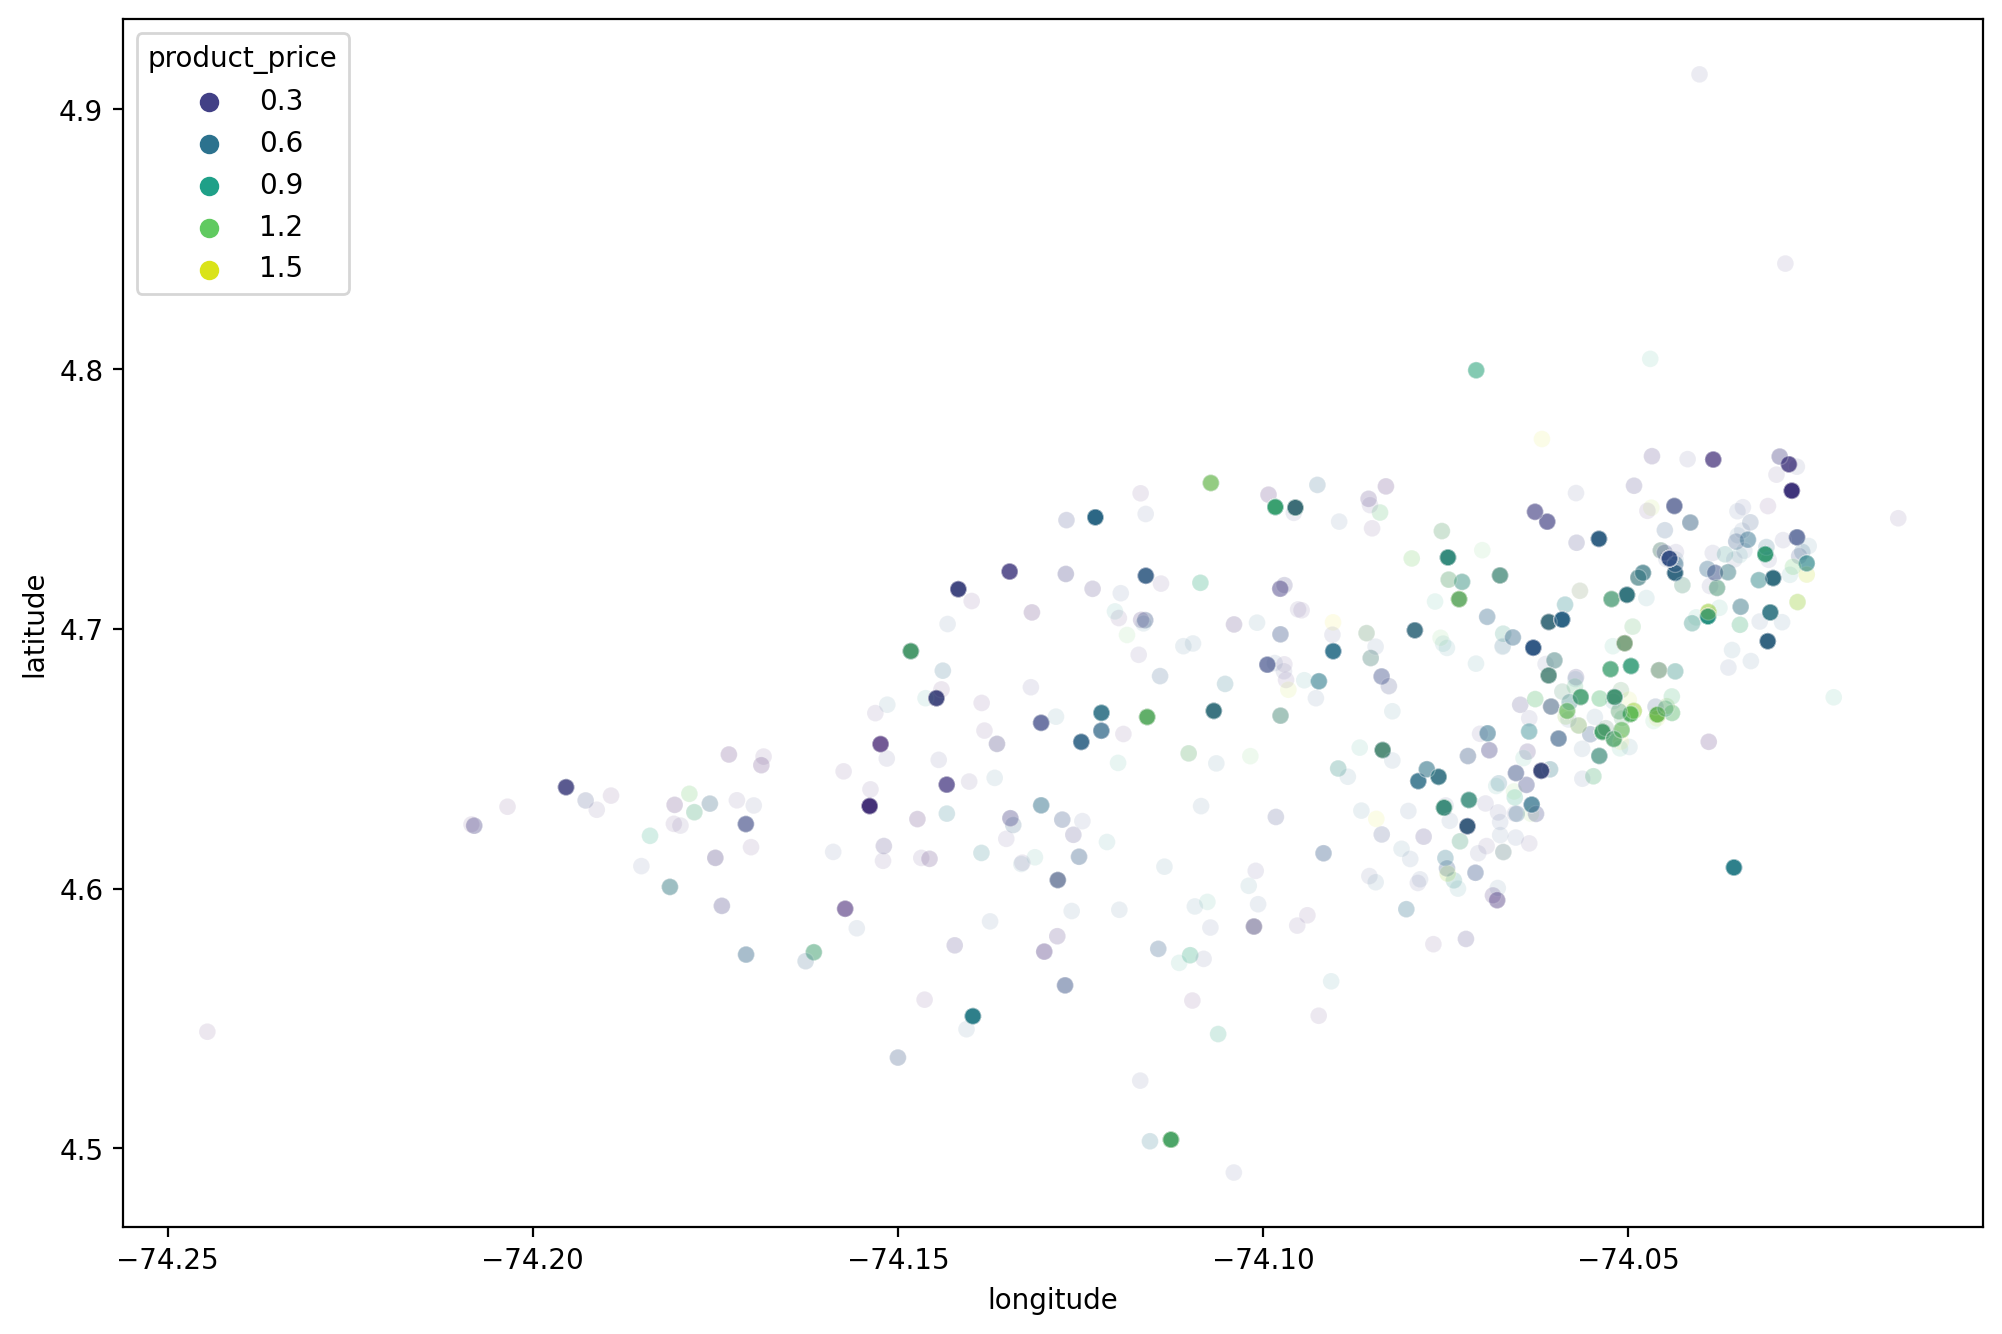

In [ ]:
plt.figure(figsize=(12,8),dpi=200)
sns.scatterplot(data=df,x='longitude', y='latitude',hue='product_price',palette='viridis',alpha=0.1);
# plt.xlim(-75,-73)
# plt.ylim(4,5)

### Plot Map of Bogotá

In [ ]:
!pip install geopandas
import geopandas as gdp
street_map = gdp.read_file('/content/drive/MyDrive/ML Projects/Bogota housing/scat.shp')

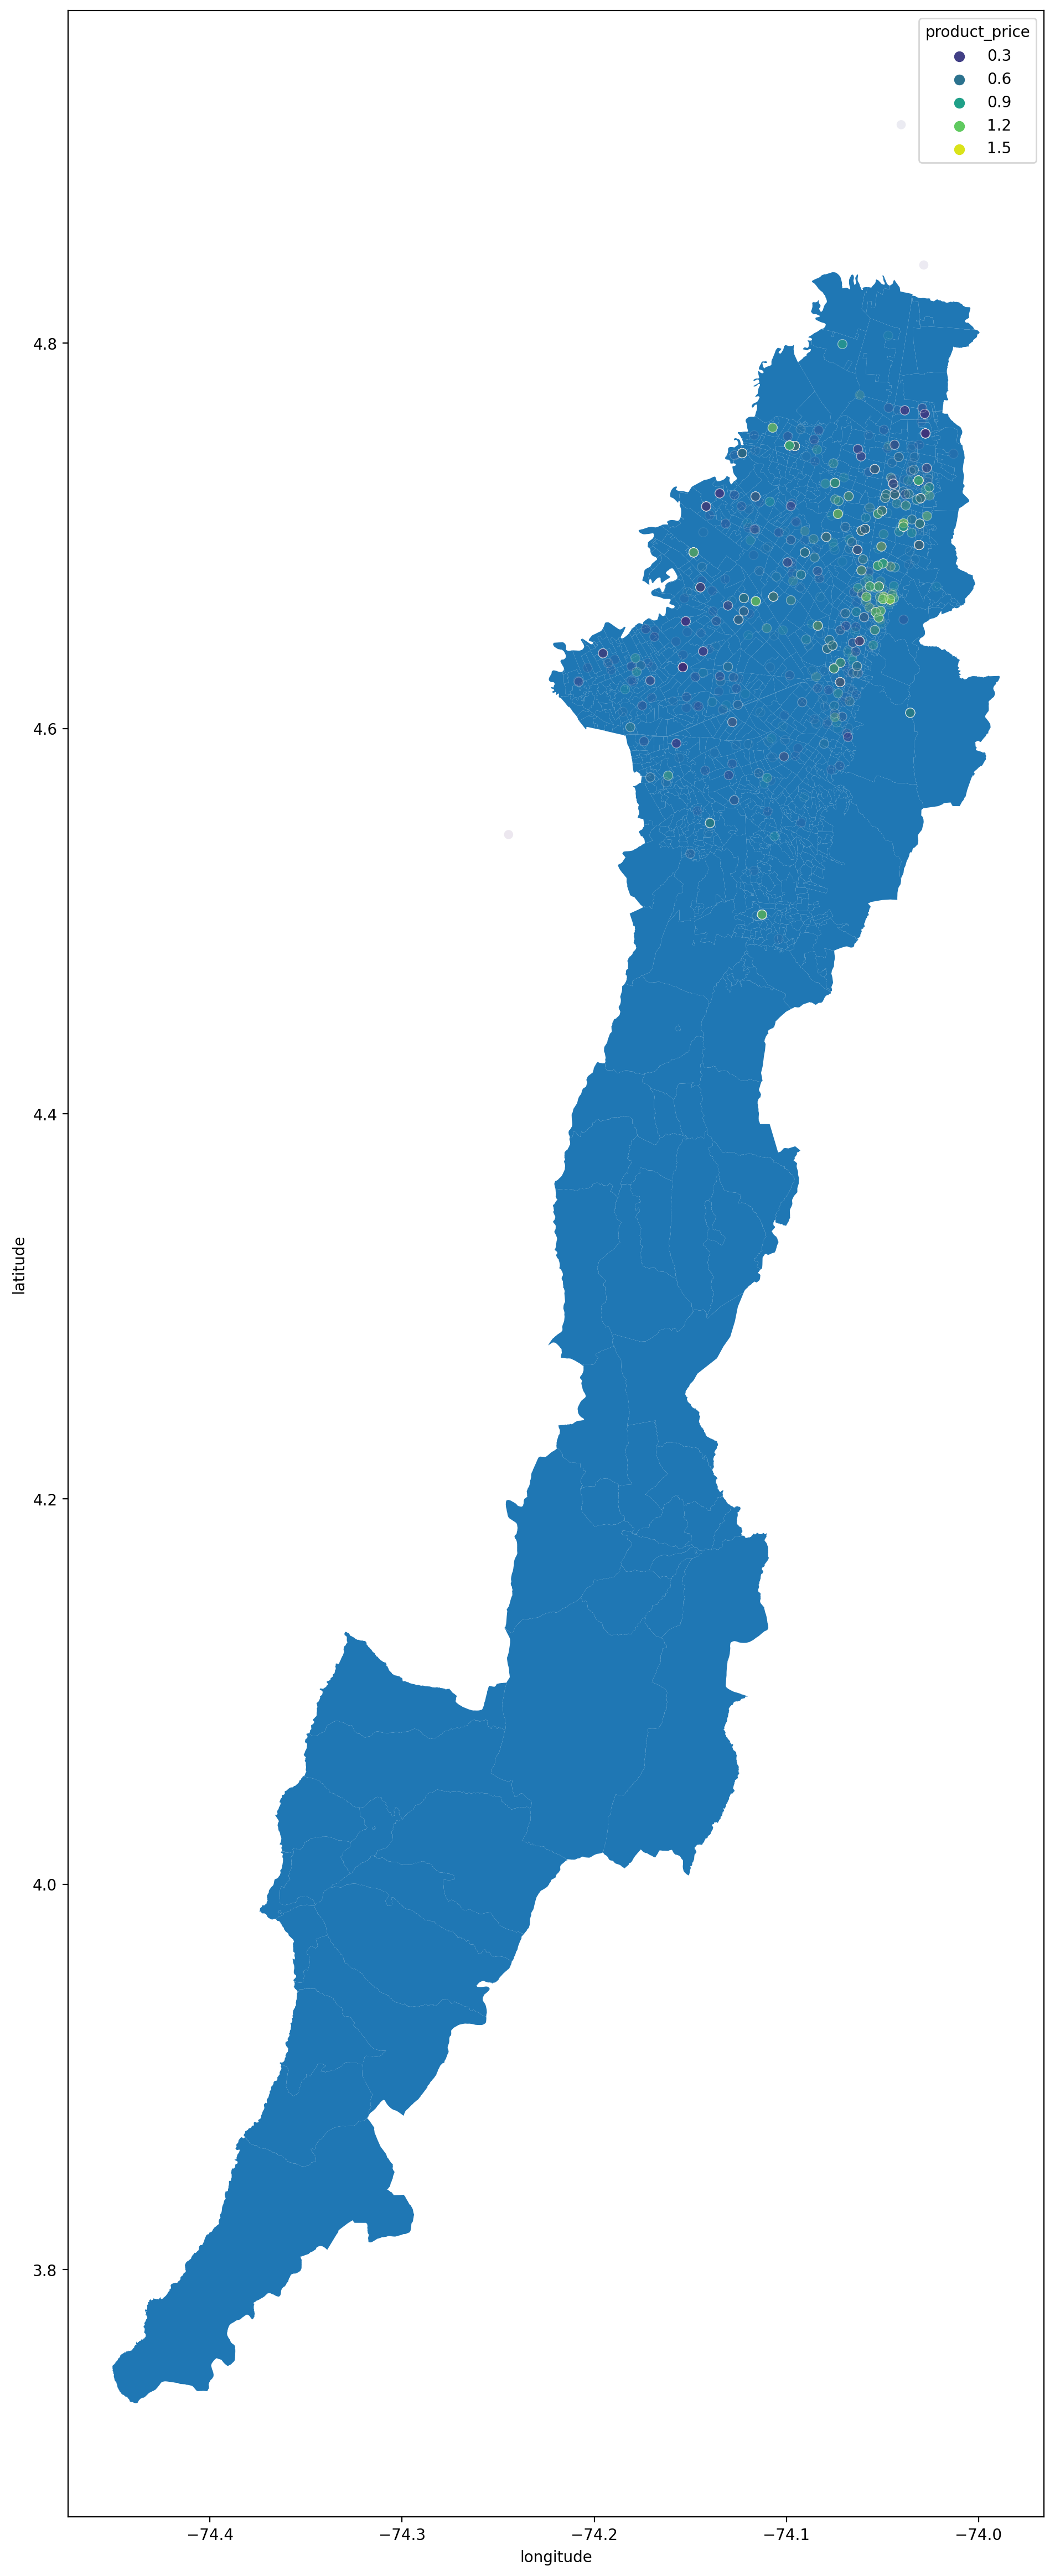

In [ ]:
fig, ax = plt.subplots(figsize=(30,30),dpi=200)
street_map.plot(ax=ax)
sns.scatterplot(data=df,x='longitude', y='latitude',hue='product_price',palette='viridis',alpha=0.1);


In [ ]:
!pip install gmplot

     |████████████████████████████████| 164 kB 5.1 MB/s 


In [ ]:
from gmplot import *

latitude_list = list(apartamentos_casas.latitude)
longitude_list = list(apartamentos_casas.longitude)
text = list(str(apartamentos_casas.product_price))
gmap = gmplot.GoogleMapPlotter(4.688954, -74.070532, 11)
gmap.scatter( latitude_list, longitude_list, "#20B2AA", size = 12, marker = True,text='text')
gmap.draw( "./bogota_map11.html" )

### More Data Visualizations

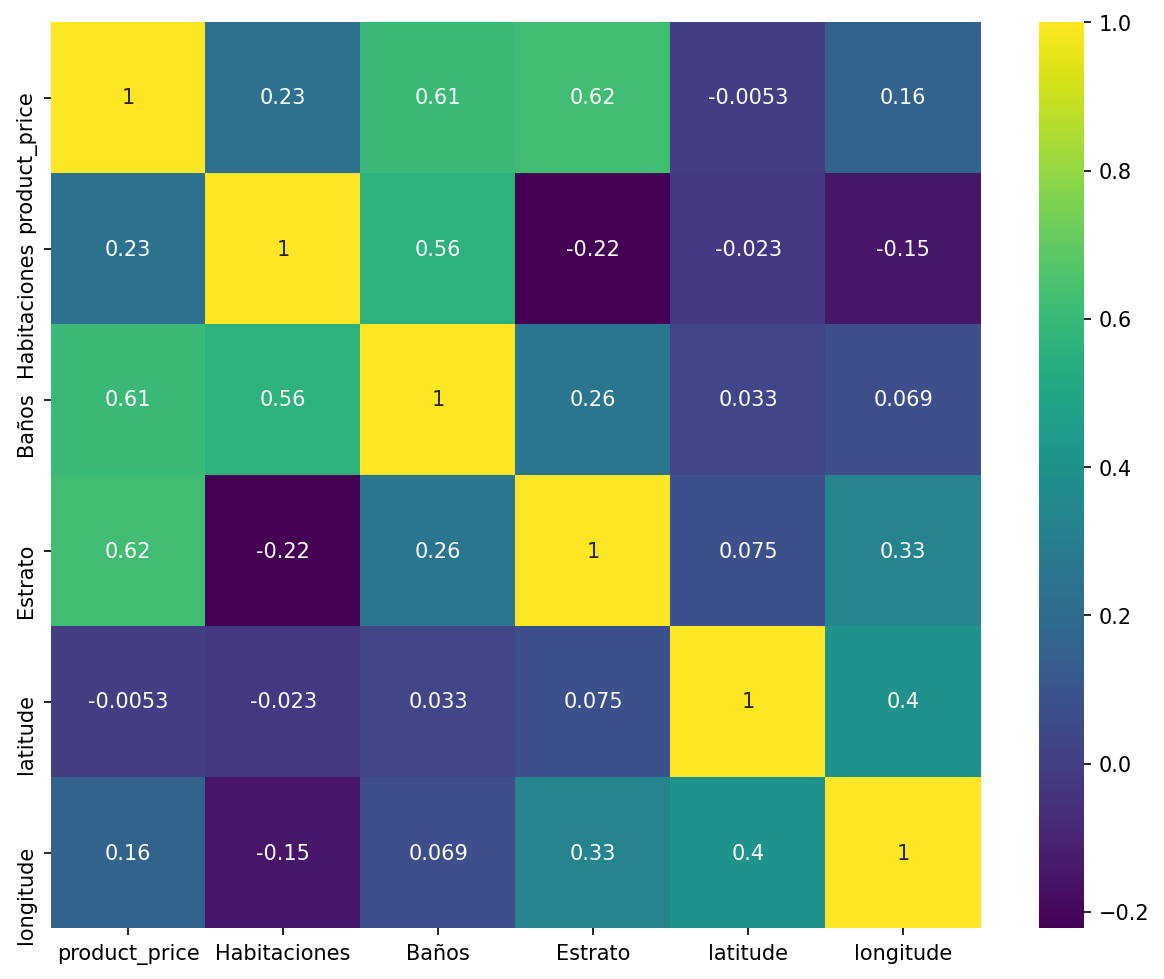

In [ ]:
## Correlations Table
plt.figure(figsize=(10,8),dpi=150);
sns.heatmap(df.corr(), cmap='viridis',annot=True);

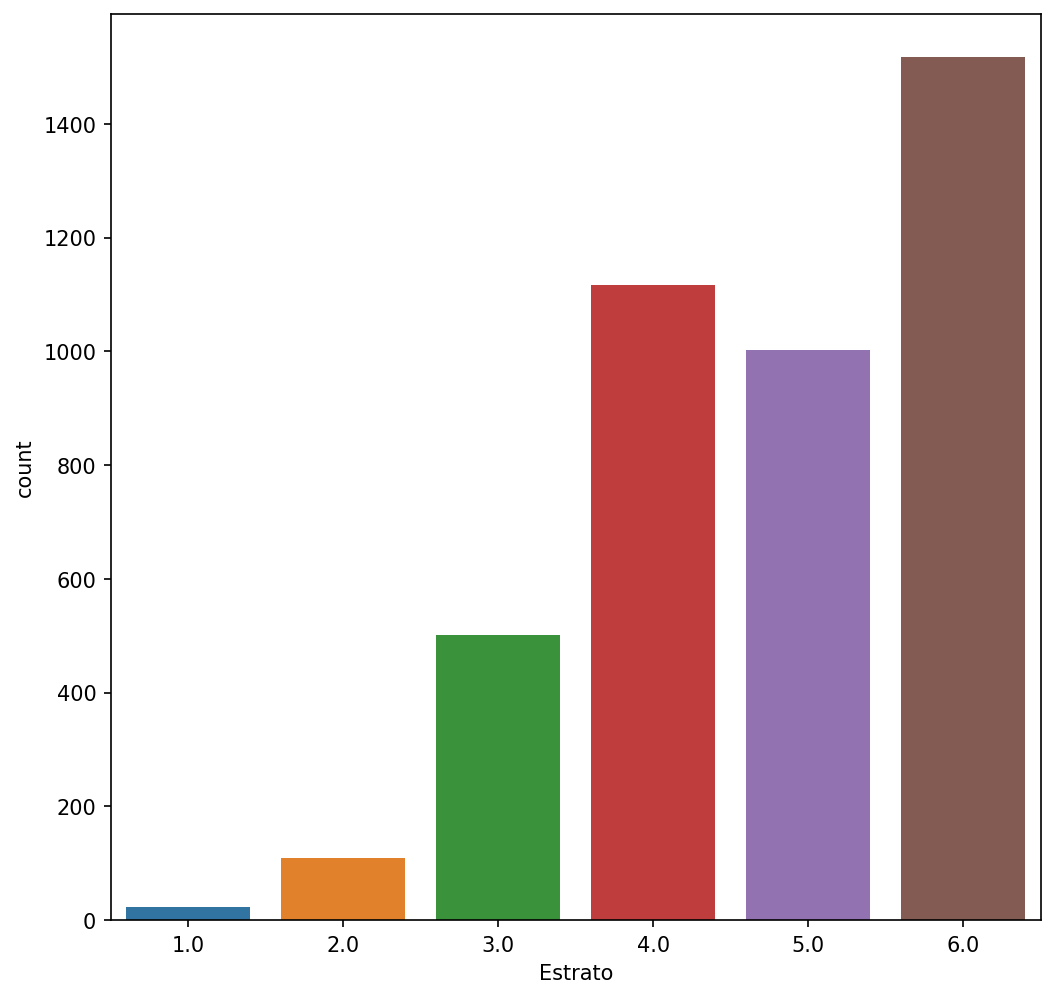

In [ ]:
plt.figure(figsize=(8,8), dpi=150)
sns.countplot(data=df, x='Estrato');

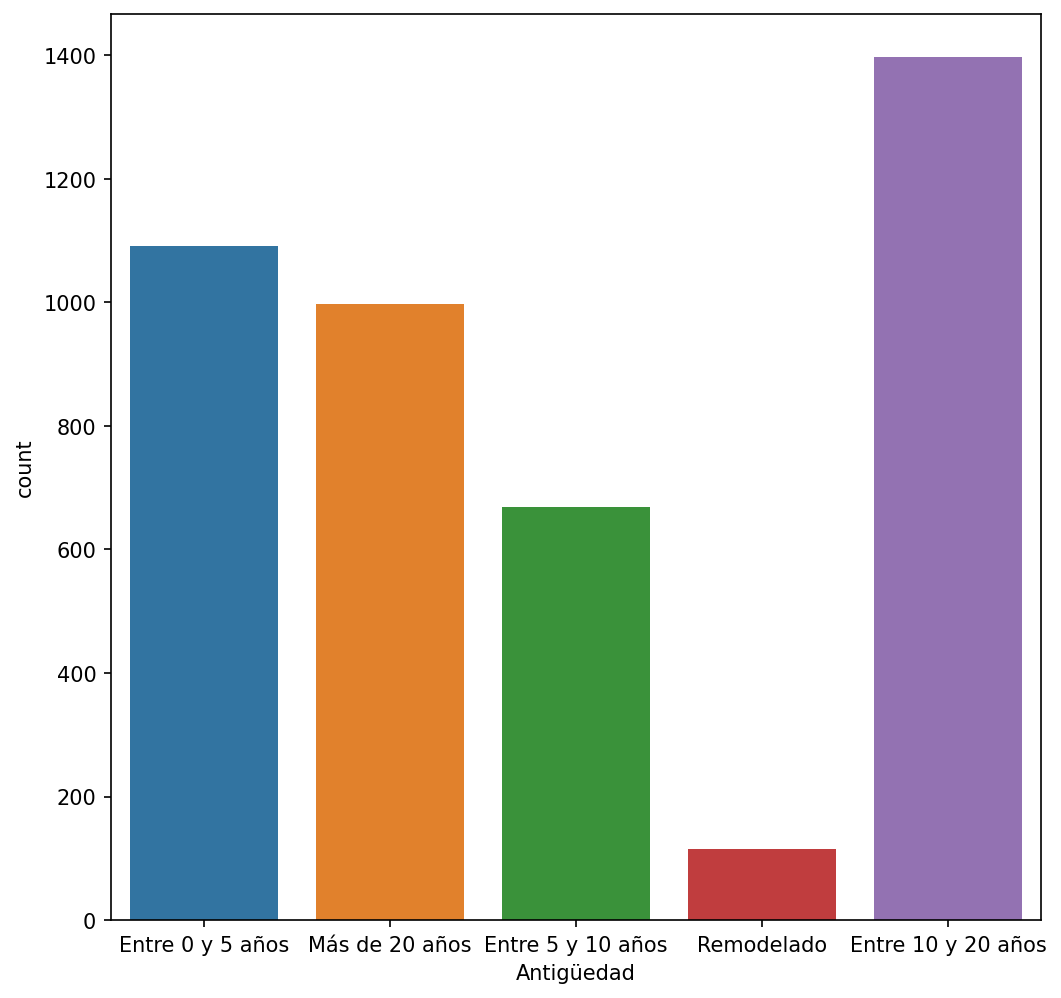

In [ ]:
plt.figure(figsize=(8,8), dpi=150)
sns.countplot(data=df, x='Antigüedad')

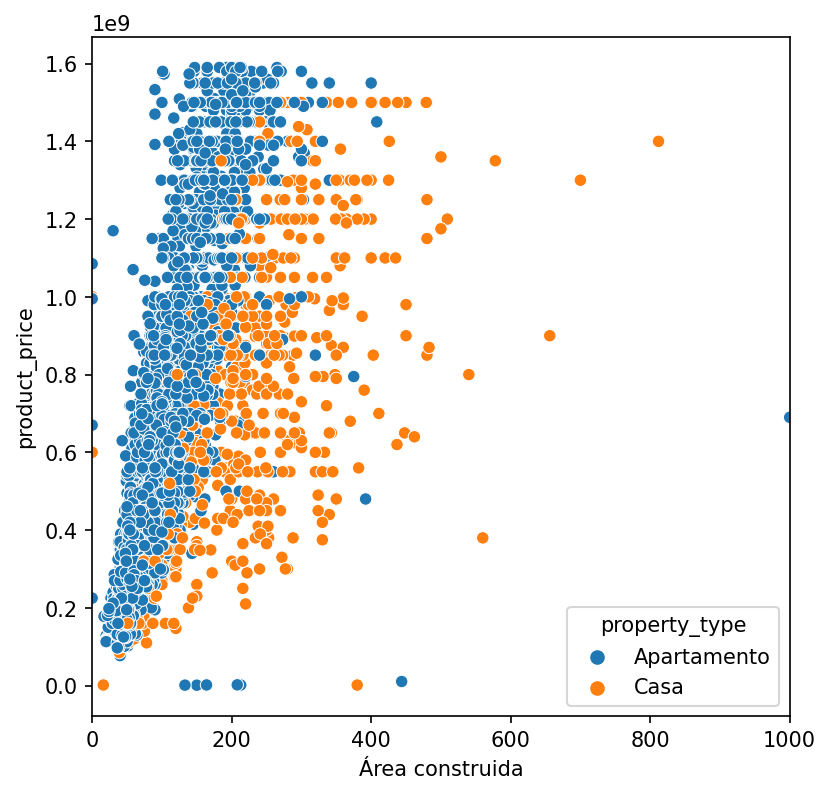

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
sns.scatterplot(data = df, x='Área construida', y='product_price', hue='property_type')
plt.xlim(0,1000);

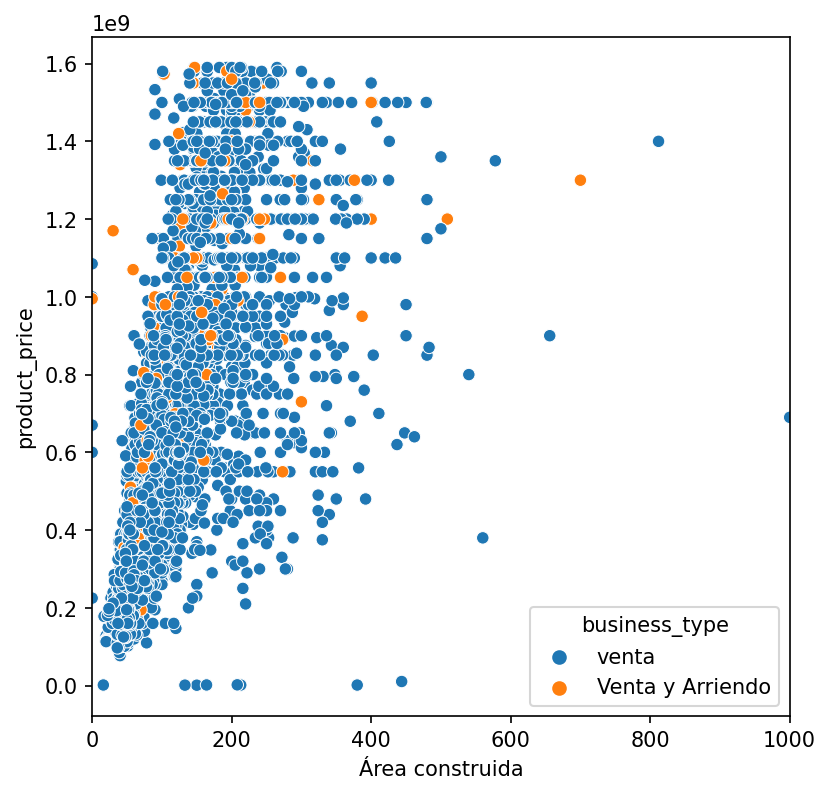

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
sns.scatterplot(data = df, x='Área construida', y='product_price', hue='business_type')
plt.xlim(0,1000);

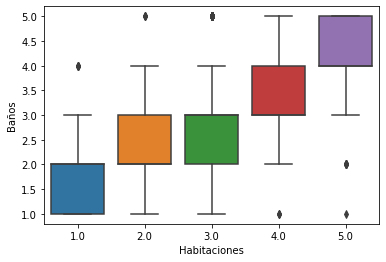

In [ ]:
sns.boxplot(data=df, x='Habitaciones',y='Baños')

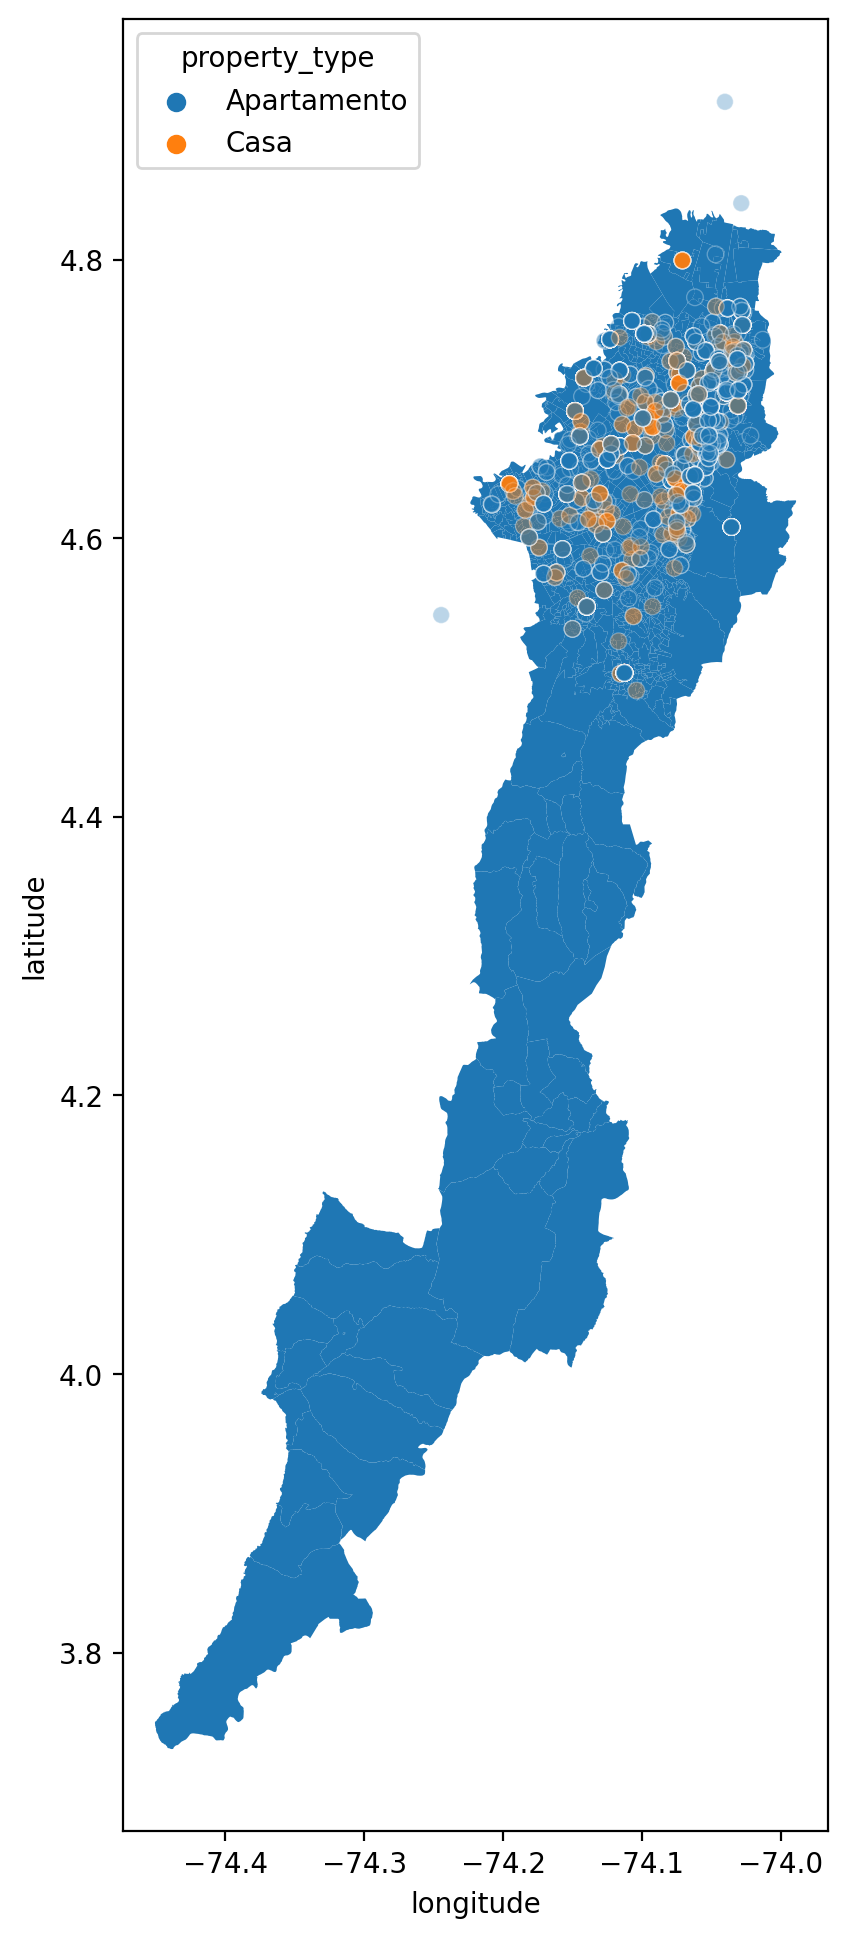

In [ ]:
fig, ax = plt.subplots(figsize=(12,12),dpi=200)
street_map.plot(ax=ax)
sns.scatterplot(data=df,x='longitude', y='latitude',hue='property_type',alpha=0.3);

In [ ]:
df.columns

Index(['product_price', 'business_type', 'property_type', 'Habitaciones',
       'Baños', 'Estrato', 'Código inmueble', 'Antigüedad', 'Área construida',
       'Área privada', 'latitude', 'longitude'],
      dtype='object')

In [ ]:
df = df.rename(columns={'Habitaciones': 'habitaciones', 'Baños': 'baños', 'Estrato':'estrato','Antigüedad':'construction_age', 'Área construida':'area', 'Área privada':'private_area'})

In [ ]:
df.head()

,product_price,business_type,property_type,habitaciones,baños,estrato,Código inmueble,construction_age,area,private_area,latitude,longitude
0,650000000,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Entre 0 y 5 años,102.0,102.0,4.653333,-74.083652
1,1500000000,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Entre 0 y 5 años,210.0,210.0,4.653333,-74.083652
3,330000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Más de 20 años,53.0,53.0,4.653333,-74.083652
5,870000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005012,Más de 20 años,83.0,83.0,4.653333,-74.083652
6,1100000000,venta,Apartamento,3.0,4.0,5.0,11812-M3005019,Entre 0 y 5 años,160.0,160.0,4.653333,-74.083652


In [ ]:
#df.to_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## 7. Applying Machine Learning to the data

In [ ]:
# df.to_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')
# LOAD THE DATA
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv',index_col=None)
df.head()

,Unnamed: 0,Unnamed: 0.1,product_price,business_type,property_type,habitaciones,baños,estrato,Código inmueble,construction_age,area,private_area,latitude,longitude
0,0,0,650000000,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Entre 0 y 5 años,102.0,102.0,4.653333,-74.083652
1,1,1,1500000000,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Entre 0 y 5 años,210.0,210.0,4.653333,-74.083652
2,2,3,330000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Más de 20 años,53.0,53.0,4.653333,-74.083652
3,3,5,870000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005012,Más de 20 años,83.0,83.0,4.653333,-74.083652
4,4,6,1100000000,venta,Apartamento,3.0,4.0,5.0,11812-M3005019,Entre 0 y 5 años,160.0,160.0,4.653333,-74.083652


In [ ]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df.head()

,product_price,business_type,property_type,habitaciones,baños,estrato,Código inmueble,construction_age,area,private_area,latitude,longitude
0,650000000,venta,Apartamento,2.0,1.0,6.0,11812-M3005003,Entre 0 y 5 años,102.0,102.0,4.653333,-74.083652
1,1500000000,venta,Apartamento,2.0,2.0,6.0,11812-M3005023,Entre 0 y 5 años,210.0,210.0,4.653333,-74.083652
2,330000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005002,Más de 20 años,53.0,53.0,4.653333,-74.083652
3,870000000,venta,Apartamento,1.0,2.0,5.0,11812-M3005012,Más de 20 años,83.0,83.0,4.653333,-74.083652
4,1100000000,venta,Apartamento,3.0,4.0,5.0,11812-M3005019,Entre 0 y 5 años,160.0,160.0,4.653333,-74.083652


In [ ]:
df.describe()

,product_price,habitaciones,baños,estrato,area,private_area,latitude,longitude
count,4.269000e+03,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000
mean,7.174978e+08,2.691263,2.721246,4.761068,135.009707,120.716995,4.689821,-74.069346
std,4.142315e+08,0.961426,1.014917,1.159926,309.150562,290.637783,0.050651,0.037378
min,7.700000e+07,1.000000,1.000000,1.000000,0.000000,0.000000,4.490724,-74.244562
25%,3.960000e+08,2.000000,2.000000,4.000000,75.000000,66.000000,4.666970,-74.095603
50%,6.400000e+08,3.000000,3.000000,5.000000,110.000000,102.000000,4.703549,-74.053564
75%,9.800000e+08,3.000000,3.000000,6.000000,163.000000,155.000000,4.727045,-74.044385
max,1.047200e+10,5.000000,5.000000,6.000000,18425.000000,18425.000000,4.913417,-74.013065


In [ ]:
%cd '/content/drive/MyDrive/ML Projects/Bogota housing'

/content/drive/MyDrive/ML Projects/Bogota housing


In [ ]:
%ls

 bogota_housing_encoder_features.pkl        results.pkl
 bogota_housing_encoder.pkl                 scat.cpg
 bogota_housing_scaler.pkl                  scat.dbf
 bogota_map11.html                          scat.prj
 Bogota_residential_Sales.csv               scat.sbn
 compra_usado_bogota.csv                    scat.sbx
 compra_usado_bogotadatos_especificos.csv   scat.shp
 coordinates.pickle                         scat.shp.xml
 coor.pickle                                scat.shx
 housing_residential_final.csv              vivienda_antes_outliers.csv
'Metro Cuadrado.ipynb'


In [ ]:
results = []

### 1. Linear Regression

#### ElasticNet

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
lin_model = ElasticNet()

param_grid = {'alpha':[100.1,100.2,102],
              'l1_ratio':[0.01,0.2,0.4,0.5,0.7,1]}

linear_grid = GridSearchCV(lin_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['Unnamed: 0','product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
linear_grid.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3461514416157491e+17, tolerance: 4.671362931003812e+16
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3435603899108557e+17, tolerance: 4.671362931003812e+16
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2981708043072307e+17, tolerance: 4.671362931003812e+16
  positive)


GridSearchCV(cv=10, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [100.1, 100.2, 102],
                         'l1_ratio': [0.01, 0.2, 0.4, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
linear_grid.best_params_

{'alpha': 102, 'l1_ratio': 1}

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = linear_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)

MAE: 188633047.99905828 , MSE: 6.610430004831221e+16 , RMSE: 257107565.13240176


In [ ]:
results.append([{'lin_grid':{'MAE': 188962400.01473343 , 'MSE': 6.853778197283452e+16 , 'RMSE': 261797215.3649357}}])

#### Lasso 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
lasso_model = Lasso()

param_grid = {'alpha':[0.5,1,2,3,5,10]}

lasso_grid = GridSearchCV(lasso_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['Unnamed: 0','product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
lasso_grid.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.637250528499895e+19, tolerance: 4.709786916603385e+16
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4427201812617708e+19, tolerance: 4.7374470299433304e+16
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.379282158879855e+19, tolerance: 4.671362931003812e+16
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 2, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = linear_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'lasso_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])

MAE: 188633047.99905828 , MSE: 6.610430004831221e+16 , RMSE: 257107565.13240176


#### Ridge

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
ridge_model = Ridge()

param_grid = {'alpha':[0.2, 0.5,1,2,3,5,10],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ridge_grid = GridSearchCV(ridge_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['Unnamed: 0','product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.2, 0.5, 1, 2, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = ridge_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'ridge_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])

MAE: 187615510.8104057 , MSE: 6.136081163344019e+16 , RMSE: 247711145.55756307


### 2. K Nearest Neighbors

In [ ]:
# IMPORTS
from sklearn.neighbors import KNeighborsRegressor

In [ ]:

# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
KNN_model = KNeighborsRegressor()

param_grid = {'n_neighbors':[5,10,30],
              'weights':['uniform', 'distance'],
              'leaf_size': [10,30,100],
              'p': [1,5,10]}

KNN_grid = GridSearchCV(KNN_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['Unnamed: 0','product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
KNN_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [10, 30, 100], 'n_neighbors': [5, 10, 30],
                         'p': [1, 5, 10], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
## Results
print(KNN_grid.best_params_)

from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = KNN_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'KNN_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])

{'leaf_size': 10, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
MAE: 144529731.7964604 , MSE: 3.798337529151234e+16 , RMSE: 194893240.7537838


In [ ]:
results

[[{'lin_grid': {'MAE': 188962400.01473343,
    'MSE': 6.853778197283452e+16,
    'RMSE': 261797215.3649357}}],
 [{'lasso_grid': {'MAE': 188633047.99905828,
    'MSE': 6.610430004831221e+16,
    'RMSE': 257107565.13240176}}],
 [{'ridge_grid': {'MAE': 187615510.8104057,
    'MSE': 6.136081163344019e+16,
    'RMSE': 247711145.55756307}}],
 [{'KNN_grid': {'MAE': 144529731.7964604,
    'MSE': 3.798337529151234e+16,
    'RMSE': 194893240.7537838}}]]

### 3. Support Vector Machines

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
svr_model = SVR()

param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'C': [0.5,0.7,1,3,10]
              }

svr_grid = GridSearchCV(svr_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['Unnamed: 0','product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
svr_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 0.7, 1, 3, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
svr_grid.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = svr_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'svr_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])

MAE: 325846944.71280295 , MSE: 1.617243429796336e+17 , RMSE: 402149652.46737885


In [ ]:
joblib.dump(results, './results.pkl')

['./results.pkl']

### 4. Random Forest

In [5]:
%cd '/content/drive/MyDrive/ML Projects/Bogota housing'

/content/drive/MyDrive/ML Projects/Bogota housing


In [6]:
%ls

 bogota_housing_encoder_features.pkl        Production/
 bogota_housing_encoder.pkl                 results.pkl
 bogota_housing_scaler.pkl                  scat.cpg
 bogota_map11.html                          scat.dbf
 Bogota_residential_Sales.csv               scat.prj
 compra_usado_bogota.csv                    scat.sbn
 compra_usado_bogotadatos_especificos.csv   scat.sbx
 coordinates.pickle                         scat.shp
 coor.pickle                                scat.shp.xml
 housing_residential_final.csv              scat.shx
'Metro Cuadrado coordinates.ipynb'         'Selenium Metro Cuadrado.ipynb'
'Metro Cuadrado.ipynb'                      vivienda_antes_outliers.csv


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [11]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
random_forest_model = RandomForestRegressor()


param_grid = {'n_estimators':[64,100,128,200],
              'max_features': [2,3,4],
              'bootstrap': [True,False],
              'oob_score': [True,False]
              }

random_forest_grid = GridSearchCV(random_forest_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [12]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')
df = df.drop(['Código inmueble'], axis=1)
joblib.dump(list(df.columns), './Production/bogota_housing_parameters.pkl')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, './Production/bogota_housing_encoder.pkl')
# joblib.dump(list(encoder.get_feature_names()), './Production/bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['product_price'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, './Production/bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
random_forest_grid.fit(X_train_scaled, y_train)
joblib.dump(random_forest_grid, './Production/bogota_housing_model.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [13]:
random_forest_grid.best_params_

{'bootstrap': False,
 'max_features': 2,
 'n_estimators': 200,
 'oob_score': False}

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = random_forest_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'random_forest_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])
joblib.dump(results, './results.pkl')

MAE: 103663977.6153655 , MSE: 2.3345872141061492e+16 , RMSE: 152793560.53532326


### 5. XG - Boost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
# define primary objects
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
xg_boost_model = XGBRegressor()


param_grid = {'n_estimators':[64,100,128,200,300],
              'booster': ['gbtree', 'gblinear', 'dart']
              }

xg_boost_grid = GridSearchCV(xg_boost_model,param_grid,scoring='neg_mean_absolute_error',cv=10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Bogota housing/housing_residential_final.csv')

## ONE HOT ENCODE DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(encoder.fit_transform(df_2).toarray(), columns=list(encoder.get_feature_names()))
joblib.dump(encoder, 'bogota_housing_encoder.pkl')
joblib.dump(list(encoder.get_feature_names()), 'bogota_housing_encoder_features.pkl')
df = df.join(df_2)

## SPLIT DATA
X = df.drop(['product_price','Código inmueble'],axis=1)
y = df['product_price']

## TRAIN - TEST SPLIT
random_state = 194
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## SCALE DATA
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'bogota_housing_scaler.pkl')

X_test_scaled = scaler.transform(X_test)


## APPLY GRID 
xg_boost_grid.fit(X_train_scaled, y_train)

[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'n_estimators': [64, 100, 128, 200, 30

In [ ]:
xg_boost_grid.best_params_

{'booster': 'gbtree', 'n_estimators': 300}

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = xg_boost_grid.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
print('MAE:',MAE,",","MSE:",MSE,",","RMSE:",RMSE)
results.append([{'xg_boost_grid':{'MAE': MAE, 'MSE': MSE , 'RMSE': RMSE}}])
joblib.dump(results, './results.pkl')

MAE: 107005566.46132009 , MSE: 3.023697500792684e+16 , RMSE: 173887823.05822003


['./results.pkl']

In [ ]:
results

[[{'lin_grid': {'MAE': 188962400.01473343,
    'MSE': 6.853778197283452e+16,
    'RMSE': 261797215.3649357}}],
 [{'lasso_grid': {'MAE': 188633047.99905828,
    'MSE': 6.610430004831221e+16,
    'RMSE': 257107565.13240176}}],
 [{'ridge_grid': {'MAE': 187615510.8104057,
    'MSE': 6.136081163344019e+16,
    'RMSE': 247711145.55756307}}],
 [{'KNN_grid': {'MAE': 144529731.7964604,
    'MSE': 3.798337529151234e+16,
    'RMSE': 194893240.7537838}}],
 [{'svr_grid': {'MAE': 325846944.71280295,
    'MSE': 1.617243429796336e+17,
    'RMSE': 402149652.46737885}}],
 [{'random_forest_grid': {'MAE': 105044711.95320633,
    'MSE': 2.3348750634346804e+16,
    'RMSE': 152802979.79537836}}],
 [{'xg_boost_grid': {'MAE': 107005566.46132009,
    'MSE': 3.023697500792684e+16,
    'RMSE': 173887823.05822003}}]]

In [ ]:
df.describe()

,product_price,habitaciones,baños,estrato,area,private_area,latitude,longitude,x0_venta,x1_Casa,x2_Entre 10 y 20 años,x2_Entre 5 y 10 años,x2_Más de 20 años,x2_Remodelado
count,4.269000e+03,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000
mean,7.174978e+08,2.691263,2.721246,4.761068,135.009707,120.716995,4.689821,-74.069346,0.944952,0.146639,0.327243,0.156477,0.233778,0.026938
std,4.142315e+08,0.961426,1.014917,1.159926,309.150562,290.637783,0.050651,0.037378,0.228101,0.353787,0.469262,0.363349,0.423282,0.161922
min,7.700000e+07,1.000000,1.000000,1.000000,0.000000,0.000000,4.490724,-74.244562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.960000e+08,2.000000,2.000000,4.000000,75.000000,66.000000,4.666970,-74.095603,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.400000e+08,3.000000,3.000000,5.000000,110.000000,102.000000,4.703549,-74.053564,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.800000e+08,3.000000,3.000000,6.000000,163.000000,155.000000,4.727045,-74.044385,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.047200e+10,5.000000,5.000000,6.000000,18425.000000,18425.000000,4.913417,-74.013065,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 8. Deployment for production

In [19]:
# READ THE DATA

# LOAD THE DATAFRAME PROPS

bogota_housing_encoder = 

bogota_housing_parameters = 

bogota_housing_model = 

bogota_housing_scaler = 

# CONVERT DATA

df = pd.DataFrame(columns=bogota_housing_parameters)

# GET DUMMY'S FROM  DATA
df_2 = df[['business_type','property_type','construction_age']]
df = df.drop(['business_type','property_type','construction_age'], axis=1)
df_2 = pd.DataFrame(bogota_housing_encoder.fit_transform(df_2).toarray(), columns=list(bogota_housing_encoder.get_feature_names()))

df = df.join(df_2)

# SCALE THE DATA

data_scaled = scaler.transform(df)

# PREDICT ON DATA

prediction = bogota_housing_model.predict(data_scaled)

SyntaxError: ignored